# Build a Prediction Model for Ultimate

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

### Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import datetime


# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [2]:
with open('../ultimate_challenge/ultimate_data_challenge.json', 'r') as f:
    ultimate = json.load(f)

print (ultimate)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
#Transform to a dataframe
DUltimate = pd.DataFrame(ultimate)

In [4]:
DUltimate.shape

(50000, 12)

In [5]:
DUltimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Out of the 12 columns, 3 have null values: avg_rating_by_driver, avg_rating_of_driver, and phone. The avg_rating_of_driver variable is missing approximately 15% of all values. While the other variables are missing less than 1% of all values. Given that phone is key for the user to access the service, not having all the observations raises a red flag. The recommendation will be first to determine the values within it and then make a decision if is feasile to fill these NaN values or they should be removed.


In [6]:
DUltimate.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


In [7]:
#Determine the values for this critical variable
DUltimate['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [8]:
DUltimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [9]:
 DUltimate.tail()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
49995,5.63,4.2,5.0,1.0,King's Landing,2014-06-05,iPhone,2014-01-25,0.0,0,False,100.0
49996,0.00,4.0,NaN,1.0,Astapor,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0
49997,3.86,5.0,5.0,1.0,Winterfell,2014-05-22,Android,2014-01-31,0.0,0,True,100.0
49998,4.58,3.5,3.0,1.0,Astapor,2014-01-15,iPhone,2014-01-14,0.0,2,False,100.0
49999,3.49,5.0,NaN,1.0,Astapor,2014-04-20,Android,2014-01-18,0.0,0,False,0.0


In [10]:
#Convert the date variables to their correct data type
DUltimate.last_trip_date = pd.to_datetime(DUltimate.last_trip_date)
DUltimate.signup_date = pd.to_datetime(DUltimate.signup_date)

In [11]:
#Check the data type took place
DUltimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
DUltimate['signup_date'].describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

Since we are looking only for the users that were active within the preceding 30 days, we need to filter them out of the dataset. First, lets find out when was the last trip recorded in the dataset.

In [13]:
DUltimate['last_trip_date'].describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

It shows that it was July 1st at midnight so the users we are interested in are the ones who took a ride during June (since it has 30 days). How many of them are in the dataset?


In [14]:
fraction_users_retained = (DUltimate.last_trip_date >= '2014-06-01').sum() / (DUltimate.last_trip_date >= '2014-06-01').count()
fraction_users_retained

0.37608

Time to identify the 37.608% in the dataset.

In [15]:
DUltimate['active'] = (DUltimate.last_trip_date >= '2014-06-01')*1
DUltimate.tail(40)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
49960,4.68,5.0,5.0,1.00,King's Landing,2014-03-15,iPhone,2014-01-25,0.0,0,False,0.0,0
49961,14.09,5.0,4.7,1.00,King's Landing,2014-02-12,iPhone,2014-01-25,0.0,4,False,100.0,0
49962,8.13,5.0,NaN,1.00,Winterfell,2014-06-12,iPhone,2014-01-25,0.0,2,False,100.0,1
49963,8.67,4.8,4.7,1.06,Winterfell,2014-06-29,iPhone,2014-01-09,4.5,2,True,86.4,1
49964,4.80,4.6,4.5,1.04,Winterfell,2014-06-26,iPhone,2014-01-24,3.8,8,False,57.7,1
49965,3.49,5.0,4.4,1.00,Astapor,2014-05-19,iPhone,2014-01-22,0.0,4,True,88.9,0
49966,4.86,4.9,3.8,1.00,King's Landing,2014-06-21,iPhone,2014-01-31,0.0,4,True,60.0,1
49967,0.05,5.0,5.0,1.00,Winterfell,2014-01-12,Android,2014-01-12,0.0,1,False,0.0,0
49968,11.04,5.0,5.0,1.00,Astapor,2014-01-12,Android,2014-01-11,0.0,1,False,0.0,0
49969,3.75,5.0,4.3,1.33,Astapor,2014-04-05,iPhone,2014-01-29,50.0,2,True,50.0,0


In [16]:
DUltimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 4.6+ MB


## Visual Exploration

In [17]:
DUltimate.groupby('active').count()['trips_in_first_30_days'].iplot(
    kind='bar', yTitle='Number of Trips', linecolor='black', title='Number of trips an Active user took during first 30 days')


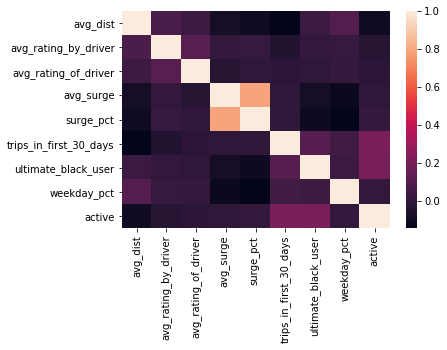

In [18]:
import seaborn as sns

fig = plt.figure()
ax = plt.subplot(111)
corr = DUltimate.corr()
ax = sns.heatmap(corr)
plt.show()

In [19]:
corr['active'].sort_values(ascending=False)

active                    1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: active, dtype: float64

It is observed that active or retained users variable has a positive weak correlation with trips_in_first_30_days and interestingly enough also with ultimate_black_user. There is neither a strong positive or negative correlations with other variables. 
Next, we shpuld determine if there is a relationship between active variable and the non-numeric columns from the set: city, phone, and the two date columns.

In [20]:
DUltimate['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

We know that phone has missing values so the options are: fill the NaNs with the most common one (iphone) or we can fill them with Other. Will go ahead and fill out them with Other.

In [21]:
DUltimate.phone.fillna('Other', inplace=True)

In [22]:
DUltimate['phone'].value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

In [23]:
DUltimate['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

To continue and build a model, City and Phone need to be hotencoded. Increasing the dimensionality should not be an issue since the potential values for the variables range from (2-3)

In [24]:
cities_ohe = pd.get_dummies(DUltimate['city'])
phones_ohe = pd.get_dummies(DUltimate['phone'])

In [25]:
DUltimate= DUltimate.join(phones_ohe).join(cities_ohe)
DUltimate

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,Android,Other,iPhone,Astapor,King's Landing,Winterfell
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1,0,0,1,0,1,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,0,0,1,1,0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1,0,0,1,0,1,0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,1,0,0,0,0,1
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,1,0,0,1,0,0,1
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,0,1,0,0,1,0,0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0,0,0,0,1,0,0,1
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0,0,1,0,0,0,0,1
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,0,1,0,0,0,0,1


In [26]:
DUltimate.drop(['city', 'phone'], axis=1, inplace=True)

In [27]:
DUltimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int64
Android                   50000 non-null uint8
Other                     50000 non-null uint8
iPhone                    50000 non-null uint8
Astapor                   50000 non-null uint8
King's Landing            50000 non-null uint8
Winterfell                50000 non-null uint8
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), uint8

In [28]:
DUltimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active,Android,Other,iPhone,Astapor,King's Landing,Winterfell
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,0,0,1,0,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,1,0,0,1,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,0,0,0,1,1,0,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,0,0,1,0,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,1,0,0,0,0,1


In [29]:
# Moving Active' to the last spot
col_at_end = ['active']
DUltimate = DUltimate[[c for c in DUltimate if c not in col_at_end]
       + [c for c in col_at_end if c in DUltimate]]

In [30]:
DUltimate.describe().iloc[:, -7:-1]

,Android,Other,iPhone,Astapor,King's Landing,Winterfell
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.300440,0.007920,0.691640,0.330680,0.202600,0.466720
std,0.458454,0.088642,0.461821,0.470463,0.401941,0.498896
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


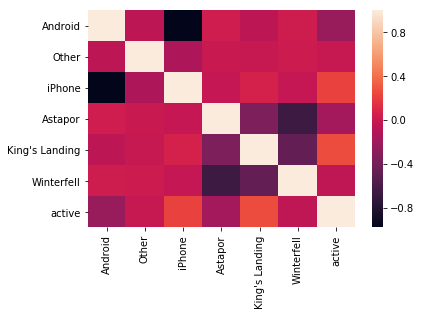

In [31]:
categoricals = DUltimate.iloc[:,-7:]
_ = plt.figure()
_ = plt.subplot(111)
corr = categoricals.corr()
_ = sns.heatmap(corr)
plt.show()

In [32]:
corr['active'].sort_values(ascending=False)

active            1.000000
King's Landing    0.262284
iPhone            0.225244
Other            -0.007419
Winterfell       -0.046611
Astapor          -0.174655
Android          -0.225464
Name: active, dtype: float64

We observed that users that are active have a weak positive correlation with King's Landing and Iphone. Now, time to tackle the columns with datetime values.

In [33]:
DUltimate.signup_date.describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [34]:
DUltimate.last_trip_date .describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [35]:
DUltimate['signup_date'] = DUltimate['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100


In [36]:
DUltimate['signup_date'].corr(DUltimate['active'])

-0.020210618434848157

In [37]:
DUltimate['last_trip_date'] = DUltimate['last_trip_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [38]:
DUltimate['last_trip_date'].corr(DUltimate['active'])

0.7767221858818666

The last_trip_date has a strong positive correlation with an user being active.

In [39]:
DUltimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null int64
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
Android                   50000 non-null uint8
Other                     50000 non-null uint8
iPhone                    50000 non-null uint8
Astapor                   50000 non-null uint8
King's Landing            50000 non-null uint8
Winterfell                50000 non-null uint8
active                    50000 non-null int64
dtypes: bool(1), float64(6), int64(4), uint8(6)
memory usage: 4.1 MB


In [40]:
DUltimate['ultimate_black_user'] = DUltimate['ultimate_black_user']*1
DUltimate.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,Android,Other,iPhone,Astapor,King's Landing,Winterfell,active
0,3.67,5.0,4.7,1.10,517,25,15.4,4,1,46.2,0,0,1,0,1,0,1
1,8.26,5.0,5.0,1.00,405,29,0.0,0,0,50.0,1,0,0,1,0,0,0
2,0.77,5.0,4.3,1.00,7,6,0.0,3,0,100.0,0,0,1,1,0,0,0
3,2.36,4.9,4.6,1.14,529,10,20.0,9,1,80.0,0,0,1,0,1,0,1
4,3.13,4.9,4.4,1.19,215,27,11.8,14,0,82.4,1,0,0,0,0,1,0


In [41]:
DUltimate['ultimate_black_user'].describe()

count    50000.00000
mean         0.37708
std          0.48466
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max          1.00000
Name: ultimate_black_user, dtype: float64

In [42]:
DUltimate['avg_rating_by_driver'] = DUltimate['avg_rating_by_driver'].fillna((DUltimate['avg_rating_by_driver'].mean()))

In [43]:
DUltimate['avg_rating_of_driver'] = DUltimate['avg_rating_of_driver'].fillna((DUltimate['avg_rating_of_driver'].mean()))

In [44]:
DUltimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null int64
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
Android                   50000 non-null uint8
Other                     50000 non-null uint8
iPhone                    50000 non-null uint8
Astapor                   50000 non-null uint8
King's Landing            50000 non-null uint8
Winterfell                50000 non-null uint8
active                    50000 non-null int64
dtypes: float64(6), int64(5), uint8(6)
memory usage: 4.5 MB


At this point, all the variables are numerical. The categorical variables were transformed to numerical values by performing one-hot-enconding. The datetime observations were converted to the actual number of days within the year.

### Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance 

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import time

In [46]:
#Features
x = DUltimate.drop(['active', 'last_trip_date'], axis=1)
# Label
y = DUltimate['active']

In [47]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
signup_date               50000 non-null int64
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null int64
weekday_pct               50000 non-null float64
Android                   50000 non-null uint8
Other                     50000 non-null uint8
iPhone                    50000 non-null uint8
Astapor                   50000 non-null uint8
King's Landing            50000 non-null uint8
Winterfell                50000 non-null uint8
dtypes: float64(6), int64(3), uint8(6)
memory usage: 3.7 MB


In [48]:
# Split dataset 
F_train, F_test, l_train, l_test = train_test_split(x, y, test_size =.25, random_state=0)

In [49]:
F_train.shape, F_test.shape, l_train.shape, l_test.shape

((37500, 15), (12500, 15), (37500,), (12500,))

In [50]:
# Initalize Logistic Regression
logregr = LogisticRegression()

# Train Model
logregr.fit(F_train, l_train)

# Test Model
y_pred = logregr.predict(F_test)

In [51]:
# Initalize Decision Tree- Gini

treeclass = DecisionTreeClassifier()

# Train Model 
treeclass.fit(F_train, l_train)

# Predict
ypredictt = treeclass.predict(F_test)

In [52]:
#Initalize Random Forest
rfc=RandomForestClassifier(n_estimators=100)

# Train 
rfc.fit(F_train, l_train)

# Predict 

ypredictr=rfc.predict(F_test)



In [53]:
#Initalize Gradient Boosting
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0)

# Train
clf.fit(F_train, l_train)

# Predict
ypredictg = clf.predict(F_test)



### How good are my models?

In [54]:
# Logistic Reg
conlog_matrix = confusion_matrix(l_test, y_pred)
conlog_matrix

array([[6683, 1125],
       [2366, 2326]])

Text(0.5, 257.44, 'Predicted label')

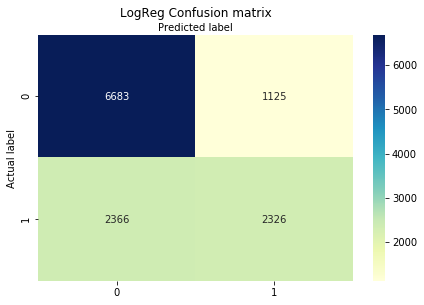

In [55]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(conlog_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('LogReg Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

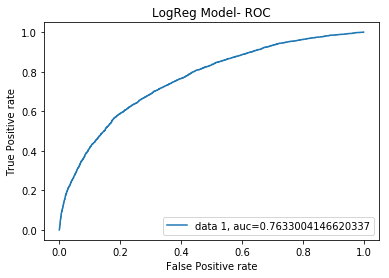

In [56]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_pred_prob = logregr.predict_proba(F_test)[:,1]
fpr, tpr, _ = roc_curve(l_test,  y_pred_prob)
auc = roc_auc_score(l_test, y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title('LogReg Model- ROC')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc=4)
plt.show()

In [57]:
# Classification for Log Reg
print(classification_report(l_test, y_pred))  

             precision    recall  f1-score   support

          0       0.74      0.86      0.79      7808
          1       0.67      0.50      0.57      4692

avg / total       0.71      0.72      0.71     12500



In [58]:
# Decision tree
contree_matrix = confusion_matrix(l_test, ypredictt)
contree_matrix

array([[5959, 1849],
       [1805, 2887]])

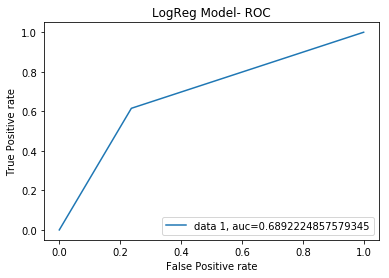

In [59]:
y_pred_prob = treeclass.predict_proba(F_test)[:,1]
fpr, tpr, _ = roc_curve(l_test,  y_pred_prob)
auc = roc_auc_score(l_test, y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.title('LogReg Model- ROC')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend(loc=4)
plt.show()

In [60]:
# Classification for Decision Tree
print(classification_report(l_test, ypredictt))  

             precision    recall  f1-score   support

          0       0.77      0.76      0.77      7808
          1       0.61      0.62      0.61      4692

avg / total       0.71      0.71      0.71     12500



In [61]:
#Confusion Matrix for Random Forest
conrfc_matrix = confusion_matrix(l_test, ypredictr)
conrfc_matrix

array([[6645, 1163],
       [1651, 3041]])

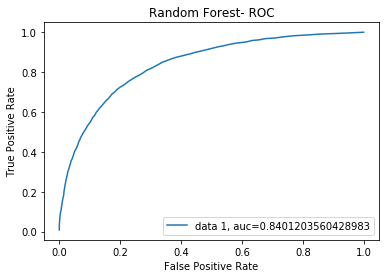

In [62]:
y_r_prob = rfc.predict_proba(F_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(l_test,  y_r_prob)
auc = roc_auc_score(l_test, y_r_prob)
plt.plot(fpr_rf,tpr_rf,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest- ROC')
plt.legend(loc=4)
plt.show()

In [63]:
# Classification for Random Forest
print(classification_report(l_test, ypredictr)) 

             precision    recall  f1-score   support

          0       0.80      0.85      0.83      7808
          1       0.72      0.65      0.68      4692

avg / total       0.77      0.77      0.77     12500



In [64]:
#Confusion Matrix for Gradient Boosting
congb_matrix = confusion_matrix(l_test, ypredictg)
congb_matrix

array([[6792, 1016],
       [1602, 3090]])

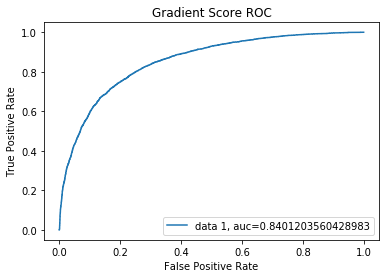

In [65]:
y_g_prob = clf.predict_proba(F_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(l_test,  y_g_prob)
auc = roc_auc_score(l_test, y_r_prob)
plt.plot(fpr_grd,tpr_grd,label="data 1, auc="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Score ROC')
plt.legend(loc=4)
plt.show()

In [66]:
# Classification for Gradient Boosting
print(classification_report(l_test, ypredictg)) 

             precision    recall  f1-score   support

          0       0.81      0.87      0.84      7808
          1       0.75      0.66      0.70      4692

avg / total       0.79      0.79      0.79     12500



From the 4 models used, there is a tie between Random Forest and Gradient Boosting since both obtained an AUC Score of 84%. Looking at the precision score for both models, it is observed that Random Forest was correct 72% of the time when it predicted users that are active while Gradient obtained at 75%. Thus, Gradient Boosting is the model that should be deployed.

One caveat that should be considered is that since there was no business direction on the classification threshold for active customer. Basically; Is business trying to minimize the false negatives (predicting that an active customer will not be active) or the false positives (predicting that a non-active customer will be active)? Due to this lack of direction, the default threshold of 50% was used. Another caveat is that once busines makes its mind, then Gradient Boosting could not longer be the optimal. 

## Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice)

One way for Ultimate to leverage the insights is by looking into the variables that Gradient Boosting found to be important when making the decision if an user is active or not.

In [67]:
pd.DataFrame(clf.feature_importances_, index = F_train.columns, columns = ['importance']).sort_values('importance', ascending=False)

,importance
avg_dist,0.218281
weekday_pct,0.165070
trips_in_first_30_days,0.100941
surge_pct,0.086924
avg_rating_by_driver,0.084288
avg_surge,0.077126
signup_date,0.071034
avg_rating_of_driver,0.066982
ultimate_black_user,0.041185
King's Landing,0.030560


The top 3 variables are avg_dist, weekday_pct, trips_in_first_30_days. We can quantify if there exists a relationship  between these variables and the label of interest: Active by calculating the correlation.

In [68]:
display(DUltimate['avg_dist'].corr(DUltimate['active']))
display(DUltimate['weekday_pct'].corr(DUltimate['active']))
display(DUltimate['trips_in_first_30_days'].corr(DUltimate['active']))

-0.09277986324064275

0.009692972843291896

0.21046322511130525

According to the results, there is a weak negative correlation with the top variable identified by the model. Ultimate should start to worry about when is a negative correlation close to 1 since it will mean that as distance increases, user is less likely to be active. 

There is a very weak positive correlation between being active and the percent of the user’s trips occurring during a weekday. Meaning that if a user starts taking less trip during the weekday, then retention of this user is at risk. 

In the case of a user being active and the number of trips in took in the first 30 days, there is a weak positive correlation. This suggest that a potential call to action is to ensure first time users ride as many trip as possible during the first 30 days so a longer lifetime value can be obtained. 
